In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

#import keras
from IPython.display import SVG
#from keras.optimizers import Adam
#from keras.utils.vis_utils import model_to_dot

from sklearn.linear_model import Ridge

%matplotlib inline

In [2]:
DATAPATH = "data/"

In [3]:
dataset = pd.read_csv(DATAPATH+"cleaned_data_train.csv", names="user_id,movie_id,prediction".split(','))
dataset['user_id'] = dataset['user_id']-1
dataset['movie_id'] = dataset['movie_id']-1
dataset.head()

,user_id,movie_id,prediction
0,43,0,4
1,60,0,3
2,66,0,4
3,71,0,3
4,85,0,5


In [4]:
table=pd.pivot_table(dataset,values='prediction',index=['user_id'],columns=['movie_id'])

In [5]:
matrix=table.fillna(0).values
del table

In [6]:
label_positions=np.logical_not(matrix==0)

In [7]:
existing_labels=np.sum(label_positions, axis=0)

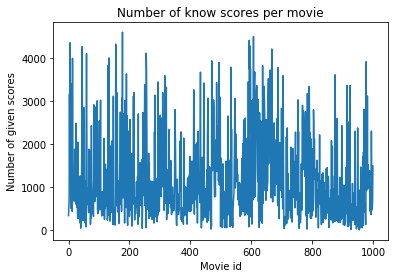

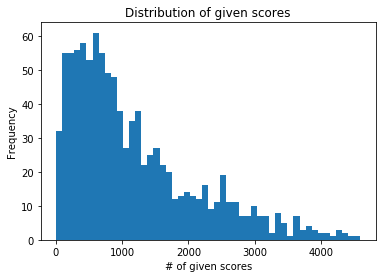

Number of movies unlabeled:  0


In [8]:
plt.plot(existing_labels)
plt.title('Number of know scores per movie')
plt.xlabel('Movie id')
plt.ylabel('Number of given scores')
plt.show()
plt.hist(existing_labels,bins=50)
plt.title('Distribution of given scores')
plt.xlabel('# of given scores')
plt.ylabel('Frequency')
plt.show()
print('Number of movies unlabeled: ', np.sum(existing_labels==0))

In [281]:
#smart iinitialization
A,B,C=np.linalg.svd(matrix,full_matrices=False)
nb_feature=100
B_reduced=np.sqrt(np.diag(B[:nb_feature]))

X=A[:,:nb_feature].dot(B_reduced)
Y=B_reduced.dot(C[:nb_feature,:])

In [237]:
def ALS(X,Y,matrix,label_positions,lambda_=.01):
    #fixing Y, optimizing X
    Xnew=X.copy()
    Ynew=Y.copy()
    n_feature=X.shape[1]
    I=np.diag(np.ones((n_feature,)))
    for u in range(X.shape[0]):
        ratings_user=matrix[u,:]
        W_user=np.diag(label_positions[u,:].squeeze())
        A=np.linalg.inv(Y.dot(W_user).dot(Y.T)+lambda_*I)
        Xnew[u,:]=ratings_user.dot(W_user).dot(Y.T).dot(A.T)
        
        if u%100==0:
            print('percent done')
    for m in range(Y.shape[1]):
        ratings_movie=matrix[:,m]
        W_movie=np.diag(label_positions[:,m].squeeze())
        A=np.linalg.inv(Xnew.T.dot(W_movie).dot(Xnew)+lambda_*I)
        Ynew[:,m]=A.dot(Xnew.T).dot(W_movie).dot(ratings_movie)
        if m%10==0:
            print('percent done')
    return Xnew,Ynew
        
        
        

In [ ]:
Xnew,Ynew=ALS(X,Y,matrix,label_positions,lambda_=.1)
Xnew2,Ynew2=ALS(Xnew,Ynew,matrix,label_positions,lambda_=.1)

percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done


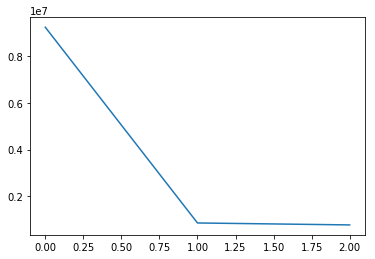

In [252]:
plt.plot(np.array([compute_error(X,Y,matrix,label_positions),compute_error(Xnew,Ynew,matrix,label_positions),compute_error(Xnew2,Ynew2,matrix,label_positions)]))

In [272]:
dataset_to_predict = pd.read_csv(DATAPATH+"cleaned_sample.csv", names="user_id,movie_id,prediction".split(','))
dataset_to_predict ['user_id'] = dataset_to_predict ['user_id']-1
dataset_to_predict ['movie_id'] = dataset_to_predict ['movie_id']-1
dataset_to_predict .head()

,user_id,movie_id,prediction
0,36,0,3
1,72,0,3
2,155,0,3
3,159,0,3
4,247,0,3


In [273]:
res_matrix=np.round(np.dot(Xnew2,Ynew2))
res_matrix[res_matrix>5]=5
res_matrix[res_matrix<1]=1
matrix_pd = pd.DataFrame(res_matrix)


matrix_pd.index.name = "user_id"
matrix_pd.columns.name="movie_id"
# joined = dataset_to_predict.set_index("user_id").join(matrix_pd,how="outer")

matrix_pd.head()

movie_id,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
user_id,,,,,,,,,,,,,,,,,,,,,
0,5.0,4.0,4.0,5.0,5.0,5.0,2.0,5.0,4.0,4.0,...,4.0,4.0,1.0,1.0,5.0,3.0,1.0,3.0,1.0,1.0
1,3.0,3.0,2.0,3.0,3.0,5.0,4.0,4.0,3.0,3.0,...,3.0,4.0,3.0,3.0,2.0,3.0,4.0,4.0,4.0,3.0
2,2.0,3.0,2.0,3.0,4.0,5.0,2.0,2.0,3.0,5.0,...,3.0,4.0,3.0,3.0,3.0,3.0,2.0,3.0,3.0,3.0
3,4.0,4.0,4.0,5.0,5.0,1.0,3.0,5.0,3.0,5.0,...,5.0,5.0,1.0,4.0,5.0,5.0,1.0,1.0,1.0,3.0
4,3.0,4.0,2.0,3.0,3.0,5.0,3.0,4.0,3.0,4.0,...,3.0,4.0,2.0,3.0,3.0,3.0,3.0,4.0,3.0,4.0


In [276]:
res=matrix_pd.stack().to_frame().reset_index(level=["user_id","movie_id"])
res.columns=["user_id","movie_id","final_predictions"]
predictors=pd.merge(dataset_to_predict,res,right_on=['user_id','movie_id'],left_on=['user_id','movie_id'],how='inner')


In [279]:
def create_submission():

    f = open(DATAPATH+"per_aspera_ad_astra.csv", "w")
    f.write("Id,Prediction\n")
    for _,d in predictors.iterrows():
        text = 'r'+str(int(d[0]+1))+'_c'+str(int(d[1]+1))+','+str(int(d[2]))+'\n'
        f.write(text)
    f.close()

In [280]:
create_submission()

In [270]:
dataset_to_predict.merge(res,right_on=['user_id','movie_id'],left_on=['user_id','movie_id'],how='inner')

,user_id,movie_id,prediction,final_predictions
0,0,3,3,5.0


## studies on small matrix

In [245]:
study_matrix=np.array([[0,2,3],[4,0,6],[7,8,9]])
study_label=study_matrix>0
#smart iinitialization
A,B,C=np.linalg.svd(study_matrix,full_matrices=False)
nb_feature=2
B_reduced=np.sqrt(np.diag(B[:nb_feature]))

X=A[:,:nb_feature].dot(B_reduced)
Y=B_reduced.dot(C[:nb_feature,:])
print(X.dot(Y))

[[ 1.45580721e+00  1.93264315e+00  2.01068789e+00]
 [ 4.05285407e+00 -2.44543593e-03  5.96408235e+00]
 [ 6.64903407e+00  8.01623839e+00  9.23850332e+00]]


In [246]:
X_new,Y_new=ALS(X,Y,study_matrix,study_label,lambda_=.01)
print(study_label)

percent done
percent done
[[False  True  True]
 [ True False  True]
 [ True  True  True]]


percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done

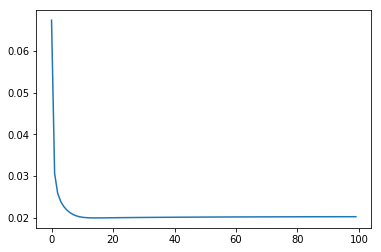

In [249]:
X_old=X.copy()
Y_old=Y.copy()
error=[]
for i in range(100):
    X_new,Y_new=ALS(X_old,Y_old,study_matrix,study_label,lambda_=.1)
    #print(X_new.dot(Y_new)
    X_old=X_new.copy()
    Y_old=Y_new.copy()
    error.append(compute_error(X_new,Y_new,study_matrix,study_label))
plt.plot(error)
print(X_old.dot(Y_old))

In [158]:
X_new=X
Y_new=Y
for i in range(10):
    X_new,Y_new=ALS2(X_new,Y_new,study_matrix,study_label,lambda_=.01)
    print(X_new.dot(Y_new))

percent done
percent done
[[-1.10684842  2.00138817  2.99304408]
 [ 3.77603079  1.07015564  5.98995107]
 [ 7.11638927  0.8960582   8.98976896]]
percent done
percent done
[[0.04126691 1.97702348 3.00246583]
 [4.16101385 0.94561267 5.99832886]
 [6.90551976 0.93021356 8.99878779]]
percent done
percent done
[[-0.82483707  2.00124432  2.99259745]
 [ 3.81052961  1.08583997  5.99036155]
 [ 7.0912223   0.89668332  8.99188542]]
percent done
percent done
[[0.11036948 1.97731763 3.0030274 ]
 [4.14403434 0.97700731 5.99741552]
 [6.91836703 0.93437289 8.99733359]]
percent done
percent done
[[-0.6096168   2.00101594  2.99208888]
 [ 3.83557188  1.10827919  5.99101507]
 [ 7.07258939  0.91012477  8.99362216]]
percent done
percent done
[[0.17245439 1.97760403 3.00358078]
 [4.13038456 1.006145   5.99660979]
 [6.92895217 0.94008689 8.99600422]]
percent done
percent done
[[-0.43822768  2.00079254  2.99159074]
 [ 3.85468962  1.13016487  5.99157585]
 [ 7.05811083  0.92400719  8.99520696]]
percent done
percen

In [130]:
%%time
Xnew,Ynew=ALS(X,Y,matrix,label_positions)

percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done
percent done

In [193]:
def compute_error(X,Y,matrix,label_pos):

    return np.sum((label_pos * (matrix - np.dot(X, Y)))**2)

In [133]:
compute_error(Xnew,Ynew,matrix,label_positions)

3.6439731618617217

## Found on
https://bugra.github.io/work/notes/2014-04-19/alternating-least-squares-method-for-collaborative-filtering/